In [72]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [73]:
# khai bao cac thu vien can thiet
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import h5py
import scipy 
from PIL import Image
from scipy import ndimage
from sklearn.decomposition import PCA
from mpl_toolkits import mplot3d

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
# ham load du lieu
def load_dataset():
  train_dataset = h5py.File("/content/gdrive/MyDrive/dataset/train_catvnoncat.h5")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:])
  train_set_y_orig = np.array(train_dataset["train_set_y"][:])

  test_dataset = h5py.File("/content/gdrive/MyDrive/dataset/test_catvnoncat.h5")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:])
  test_set_y_orig = np.array(test_dataset["test_set_y"][:])

  classes = h5py.File("/content/gdrive/MyDrive/dataset/train_catvnoncat.h5")
  return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

In [75]:
train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig =  load_dataset()

0


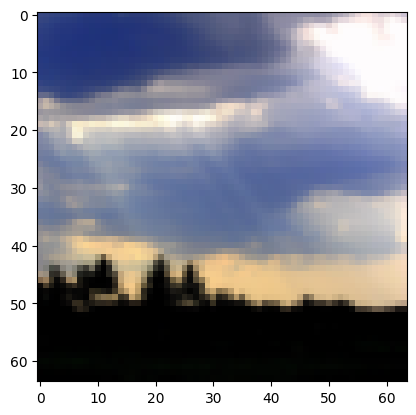

In [76]:
# hien thi hinh anh bat ky trong tap du lieu
index = 99
plt.imshow(train_set_x_orig[index])
print(train_set_y_orig[index])

In [77]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig[0].shape[0]

print("number of training examples: " + str(m_train))
print("number of test examples: " + str(m_test))
print("height/width of each image: " + str(num_px))

number of training examples: 209
number of test examples: 50
height/width of each image: 64


In [78]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

In [79]:
assert np.alltrue(train_set_x_flatten[0:9, 1] == train_set_x_orig[1][0][0:3].reshape(-1)), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:9, 1] == test_set_x_orig[1][0][0:3].reshape(-1)), "Wrong solution. Use (X.shape[0], -1).T."


In [80]:
print("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print("train_set_y_orig shape: " + str(train_set_y_orig.shape))
print("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print("test_set_y_orig shape: " + str(test_set_y_orig.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y_orig shape: (209,)
test_set_x_flatten shape: (12288, 50)
test_set_y_orig shape: (50,)


In [81]:
pca = PCA(n_components = 3)
pca.fit(train_set_x_flatten.T)
pca = pca.transform(train_set_x_flatten.T)
print(pca.shape)

(209, 3)


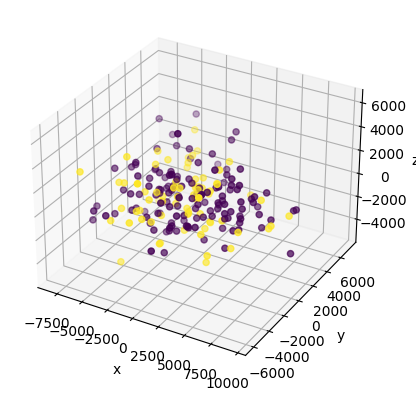

In [82]:
df_pca = pd.DataFrame(pca)
df_label = pd.DataFrame(train_set_y_orig)
df = pd.concat([df_pca, df_label], axis = 1)
df.columns = ["x", "y", "z", "label"]

ax = plt.axes(projection="3d")
ax.scatter3D(pca[:, 0], pca[:, 1], pca[:, 2], c = df["label"])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [83]:
X_train = train_set_x_flatten/255
Y_train = train_set_y_orig.reshape(1, X_train.shape[1])
X_test = test_set_x_flatten/255
Y_test = test_set_y_orig.reshape(1, X_test.shape[1])

In [84]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

In [85]:
# ham khoi tao tham so
def initialize_with_zeros(dim):
  w = np.zeros([dim, 1], dtype = int)
  b = 0.0
  return w, b

In [86]:
# ham tinh cost, dw, db
def propagate(w, b, X, Y):
  m = X.shape[1]
  A = sigmoid(np.dot(w.T, X)+b)
  cost = -(np.dot(Y, np.log(A).T)+np.dot((1-Y), np.log(1-A).T))/m
  dw = (np.dot(X, (A-Y).T))/m
  db = (np.sum(A-Y))/m
  cost = np.squeeze(np.array(cost))
  grads = {"dw": dw,
            "db": db}

  return grads, cost

In [87]:
# ham toi uu: gradient descent
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
  w = copy.deepcopy(w)
  b = copy.deepcopy(b)
  costs = []
  W = []
  B = []
  for i in range(num_iterations):
    grads, cost = propagate(w, b, X, Y)
    dw = grads['dw']
    db = grads['db']
    w = w - learning_rate*dw
    b = b - learning_rate*db
    if i%100 == 0:
      costs.append(cost)
      W.append(w)
      B.append(b)
      if print_cost:
        print ("Cost after iteration %i: %f" %(i, cost))
  return costs, W, B

In [88]:
def predict(w, b, X, Y, num_iterations, learning_rate):
  costs, W, B = optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False)
  m = X.shape[1]
  A = []
  Y_prediction = []
  Y_pre = np.zeros((1, m))
  for i in range(len(W)):
    W[i] = W[i].reshape(X.shape[0], 1)
    A.append(sigmoid(np.dot(W[i].T, X) + B[i]))
    Y_prediction.append(Y_pre)
  A = np.squeeze(A)
  Y_prediction = np.squeeze(Y_prediction)
  for i in range(A.shape[0]):
    for j in range(A.shape[1]):
      if A[i][j] > 0.5:
        Y_prediction[i][j] = 1
      else:
        Y_prediction[i][j] = 0
  return Y_prediction

In [89]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = False):
  w, b = initialize_with_zeros(X_train.shape[0])
  costs, W, B = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost = True)
  train_acc = []
  test_acc = []
  Y_prediction_test = (predict(w, b, X_test, Y_test, num_iterations, learning_rate))
  Y_prediction_train = (predict(w, b, X_train, Y_train, num_iterations, learning_rate))
  for i in range(len(W)):
    train_acc.append(100-(np.mean(np.abs((Y_prediction_train[i].astype(int)) - Y_train)))*100)
    test_acc.append(100-(np.mean(np.abs((Y_prediction_test[i].astype(int)) - Y_test)))*100)
    
  d = {"costs" : costs,
       "train_acc" : train_acc,
       "W" : W,
       "B" : B,
       "learning_rate" : learning_rate,
       "num_iterations" : num_iterations,
       "Y" : Y_prediction_train}
  return d

In [90]:
logistic_regression_model = model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872


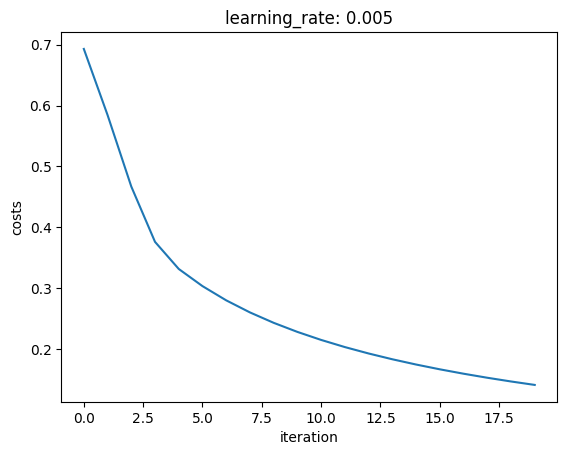

In [91]:
costs = logistic_regression_model['costs']
plt.plot(costs)
plt.ylabel("costs")
plt.xlabel("iteration")
plt.title("learning_rate: " + str(logistic_regression_model["learning_rate"]))
plt.show()

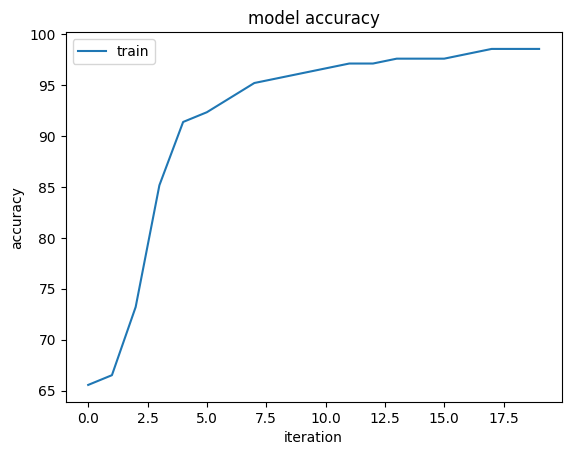

In [92]:
train_acc = logistic_regression_model['train_acc']
plt.plot(train_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['train'], loc='upper left')
plt.show()

y = 0.0


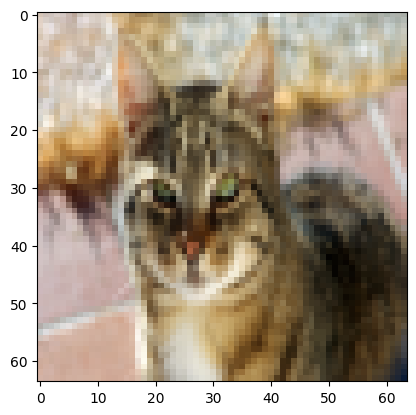

In [93]:
# Dự đoán một ảnh bất kỳ
w = np.squeeze(logistic_regression_model['W'])
b = np.squeeze(logistic_regression_model['B'])
def pre(w, b, X):
  m = X.shape[1]
  Y_prediction = np.zeros((1, m))
  w = w.reshape(X.shape[0], 1)
  A = sigmoid(np.dot(w.T, X)+b)
  for i in range(A.shape[1]):      
    if A[0, i]>0.5:
      Y_prediction[0, i] = 1 
    else:
      Y_prediction[0, i] = 0
  return Y_prediction 
fname = "/content/gdrive/MyDrive/dataset/A-Cat.jpg"
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = pre(w[19], b[19], image)

print("y = " + str(np.squeeze(my_predicted_image)))